In [1]:
from mimic.utilities import *
from mimic.model_infer.infer_CRM_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import *Clare et al* time series data

In [2]:
# Import and format the data

def get_data(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)

    # Adjust for data size and number of species as necessary
    # Take only time course up to t=400
    X1_bar = d.iloc[1:38, 1:5].mean(axis=1)

    # Calculate the mean of the second species
    X2_bar = d.iloc[1:38, 5:9].mean(axis=1)

    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:38, 0],
        'X1_bar': X1_bar,
        'X2_bar': X2_bar
    })

    # Replace negative values with 0
    obs[obs < 0] = 0

    return obs


def get_data_m(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)

    # Adjust for data size and number of species as necessary
    # Take only time course up to t=400
    X1_bar = d.iloc[1:38, 1:5].mean(axis=1)

    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:38, 0],
        'X1_bar': X1_bar,
    })

    # Replace negative values with 0
    obs[obs < 0] = 0

    return obs


In [3]:


# Define the base directory
base_path = 'Clare_fitting_data/'

# Import co-culture data
EcN_Sent_glu = get_data(base_path + "co_EcN_Sent_glu_fitting.csv")
EcN_Sent_EAB12 = get_data(base_path + "co_EcN_Sent_EAB12_fitting.csv")
EcN_Sent_EAB12glu = get_data(base_path + "co_EcN_Sent_EAB12glu_fitting.csv")

# Import monoculture data
EcN_glu = get_data_m(base_path + "mono_EcN_glu_fitting.csv")
EcN_EAB12 = get_data_m(base_path + "mono_EcN_EAB12_fitting.csv")
EcN_EAB12glu = get_data_m(base_path + "mono_EcN_EAB12glu_fitting.csv")

Sent_glu = get_data_m(base_path + "mono_Sent_glu_fitting.csv")
Sent_EAB12 = get_data_m(base_path + "mono_Sent_EAB12_fitting.csv")
Sent_EAB12glu = get_data_m(base_path + "mono_Sent_EAB12glu_fitting.csv")

all_data = pd.concat([EcN_Sent_glu.iloc[:, 0:3], EcN_Sent_EAB12.iloc[:, 1:3], EcN_Sent_EAB12glu.iloc[:, 1:3], 
                     EcN_glu.iloc[:, 1], EcN_EAB12.iloc[:, 1], EcN_EAB12glu.iloc[:, 1],
                     Sent_glu.iloc[:, 1], Sent_EAB12.iloc[:, 1], Sent_EAB12glu.iloc[:, 1]], axis=1)

import matplotlib.pyplot as plt



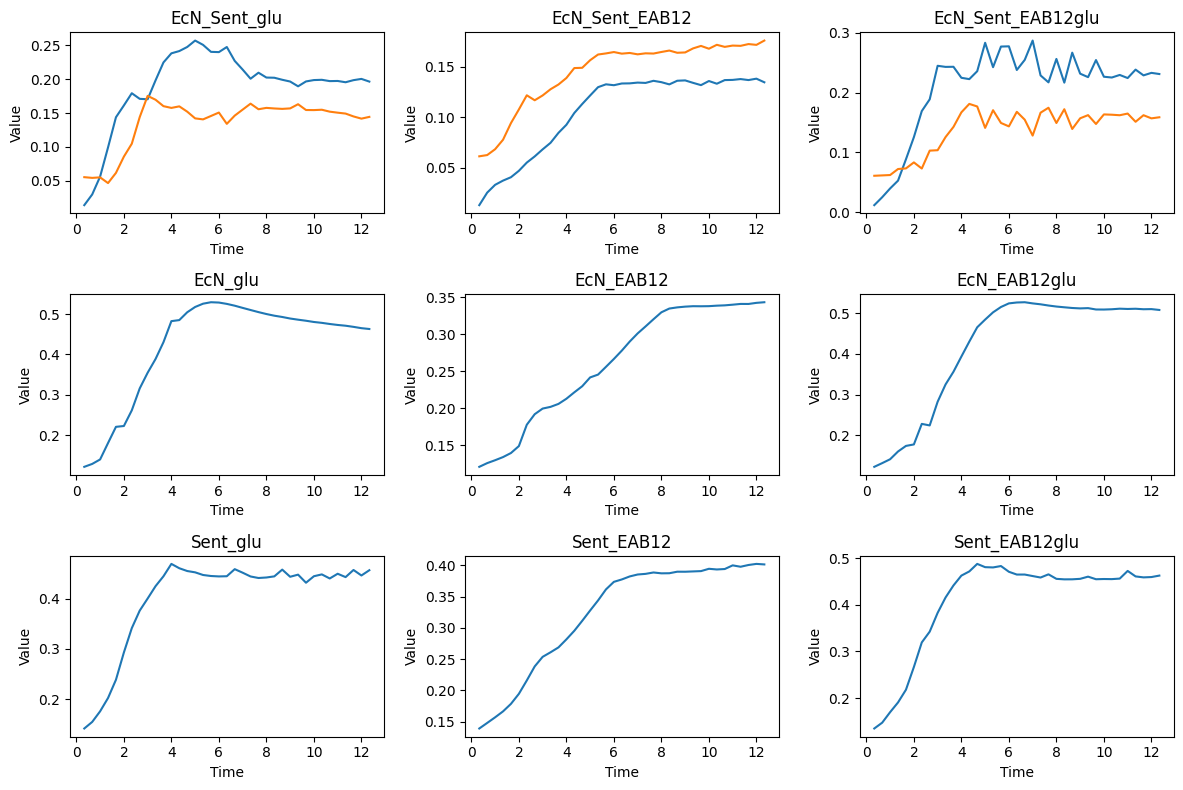

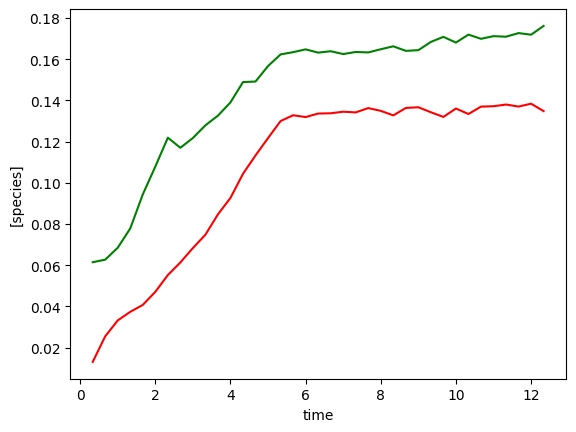

In [4]:
## Plot the growth curves for all conditions

# Define the condition names
conditions = ['EcN_Sent_glu', 'EcN_Sent_EAB12', 'EcN_Sent_EAB12glu', 
              'EcN_glu', 'EcN_EAB12', 'EcN_EAB12glu', 
              'Sent_glu', 'Sent_EAB12', 'Sent_EAB12glu']

# Link the condition names to their data
data_dict = {
    'EcN_Sent_glu': EcN_Sent_glu,
    'EcN_Sent_EAB12': EcN_Sent_EAB12,
    'EcN_Sent_EAB12glu': EcN_Sent_EAB12glu,
    'EcN_glu': EcN_glu,
    'EcN_EAB12': EcN_EAB12,
    'EcN_EAB12glu': EcN_EAB12glu,
    'Sent_glu': Sent_glu,
    'Sent_EAB12': Sent_EAB12,
    'Sent_EAB12glu': Sent_EAB12glu
}

# Create a facet plot
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

axes = axes.flatten()

for i, condition in enumerate(conditions):
    data = data_dict[condition] 
    plot_growth_curves(data, axes[i]) 
    axes[i].set_title(condition)

plt.tight_layout()
plt.show()

# Extract data and convert to numpy arrays
yobsdf = EcN_Sent_EAB12.iloc[:, [1, 2]]
yobs = yobsdf.to_numpy()
timesa = EcN_Sent_EAB12.iloc[:, 0]
times = timesa.to_numpy()

plot_gLV(yobs, times)

In [5]:
# Output folder specification
output_folder = "Clare_EcN_Sent"  # Change this for different runs
# Create output directory
os.makedirs(output_folder, exist_ok=True)

In [6]:
num_species = 2
num_resources = 2

In [7]:
# Define prior parameters

prior_tau_mean = 1.2
prior_tau_sigma = 0.3

prior_w_mean = 0.6
prior_w_sigma = 0.25

prior_c_mean = [[0.25, 0.1], [0.1, 0.25]]  
prior_c_sigma = [[0.1, 0.1], [0.1, 0.1]]

prior_m_mean = 0.2
prior_m_sigma = 0.1

prior_r_mean = 0.35
prior_r_sigma = 0.1

prior_K_mean = 6
prior_K_sigma = 1.0

# Sampling conditions
draws = 50
tune = 50
chains = 4
cores = 4


# Save model conditions to file
conditions_text = f"""Model Conditions and Priors
============================

Sampling Conditions:
- draws: {draws}
- tune: {tune}
- chains: {chains}
- cores: {cores}

Number of species: {num_species}
Number of resources: {num_resources}

Prior Parameters:
- tau: mean = {globals().get('prior_tau_mean', 'na')}, sigma = {globals().get('prior_tau_sigma', 'na')}
- w: mean = {globals().get('prior_w_mean', 'na')}, sigma = {globals().get('prior_w_sigma', 'na')}
- c: mean = {globals().get('prior_c_mean', 'na')}, sigma = {globals().get('prior_c_sigma', 'na')}
- m: mean = {globals().get('prior_m_mean', 'na')}, sigma = {globals().get('prior_m_sigma', 'na')}
- r: mean = {globals().get('prior_r_mean', 'na')}, sigma = {globals().get('prior_r_sigma', 'na')}
- K: mean = {globals().get('prior_K_mean', 'na')}, sigma = {globals().get('prior_K_sigma', 'na')}
"""

with open(os.path.join(output_folder, 'model_conditions.txt'), 'w') as f:
    f.write(conditions_text)
print(f"Saved model conditions to {output_folder}/model_conditions.txt")


Saved model conditions to Clare_EcN_Sent/model_conditions.txt


In [8]:
# Run inference

inference = inferCRMbayes()

# adjust set_parameters to include either fixed parameters, as in tau=tau, or priors 
#   to infer them, as in prior_tau_mean=prior_tau_mean, prior_tau_sigma=prior_tau_sigma

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                         prior_tau_mean=prior_tau_mean, prior_tau_sigma=prior_tau_sigma,
                         prior_w_mean=prior_w_mean, prior_w_sigma=prior_w_sigma,
                         prior_m_mean=prior_m_mean, prior_m_sigma=prior_m_sigma,
                         prior_r_mean=prior_r_mean, prior_r_sigma=prior_r_sigma,
                         prior_K_mean=prior_K_mean, prior_K_sigma=prior_K_sigma,
                         prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata, true_params=params) # saves to wd as default

# Move all the generated posterior plot files to output folder
posterior_files = glob.glob("plot-posterior-*.pdf")
for file in posterior_files:
    shutil.move(file, os.path.join(output_folder, file))

print(f"Moved {len(posterior_files)} posterior plots to output folder")


# To plot summary statistics of the posterior distributions, delete as appropriate
summary = az.summary(idata, var_names=["tau_hat", "w_hat","c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
print("Summary Statistics:")
print(summary[["mean", "sd", "r_hat"]])

# Also save to text file
summary[["mean", "sd", "r_hat"]].to_csv(os.path.join(output_folder, 'summary_statistics.txt'), sep='\t')
print("Saved summary statistics to summary_statistics.txt")

# Save posterior samples to file
az.to_netcdf(idata, os.path.join(output_folder, 'model_posterior.nc'))


#az.plot_trace(idata, var_names=["tau_hat", "w_hat","c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
az.plot_trace(idata, var_names=["c_hat", "sigma"])
plt.savefig(os.path.join(output_folder, 'posterior-trace.jpg'), dpi=300, bbox_inches='tight')
plt.close()
print("Saved posterior trace plot")



times shape: (37,)
yobs shape: (37, 2)
Number of species: 2
Number of resources: 2
tau_hat is inferred
w_hat is inferred
c_hat is inferred
m_hat is inferred
r_hat is inferred
K_hat is inferred
=== RSME ===
MODEL FAILED: operands could not be broadcast together with shapes (37,4) (37,2) 
Initial conditions (y0): [0.01304198 0.06143302 0.05       0.05      ]


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau_hat, w_hat, c_hat_vals, m_hat, r_hat, K_hat]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 5471 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


NameError: name 'params' is not defined

Plotting posterior for tau_hat


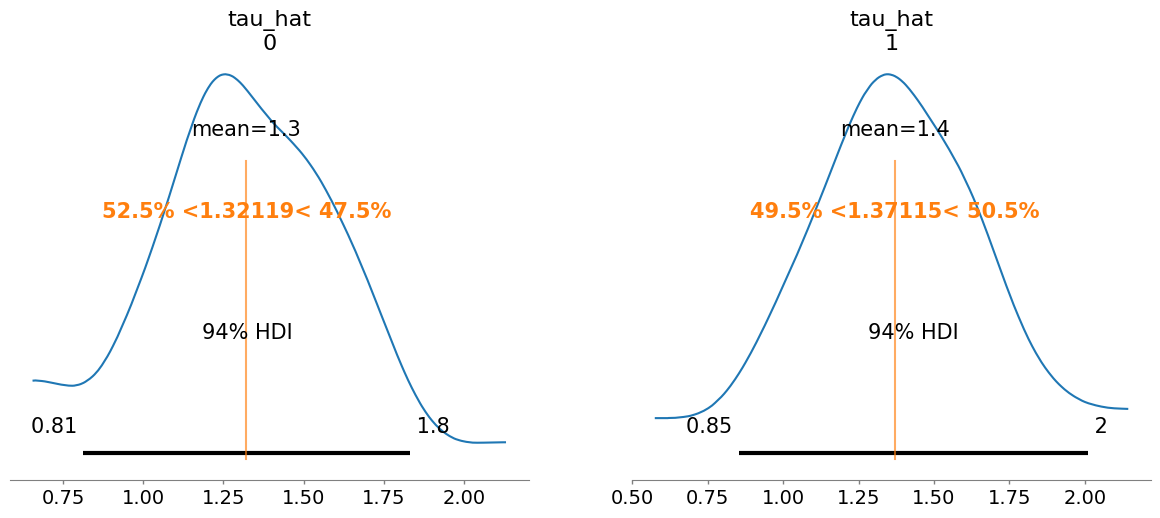

Plotting posterior for w_hat


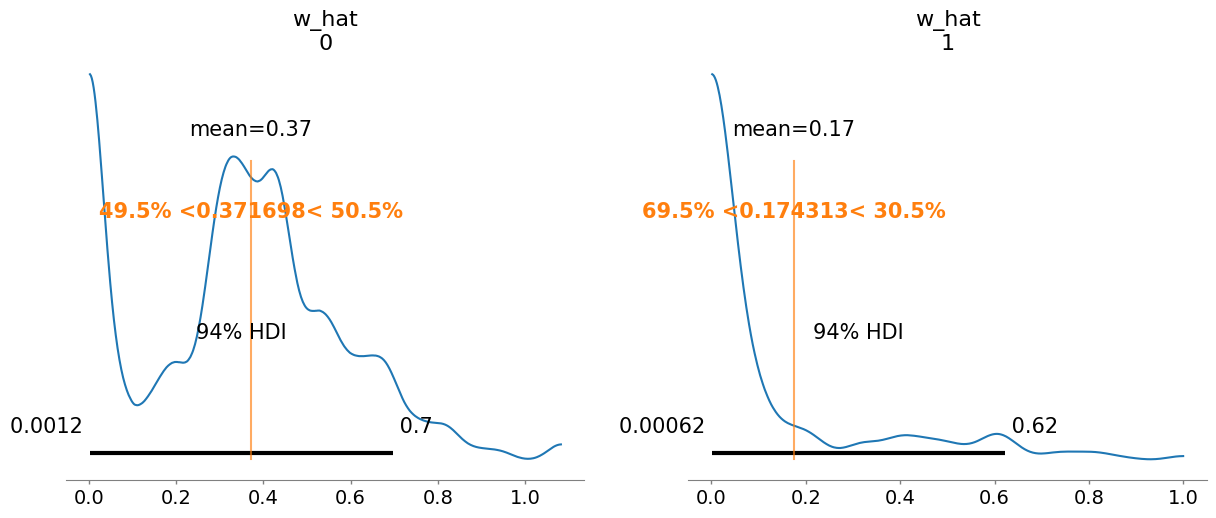

Plotting posterior for c_hat


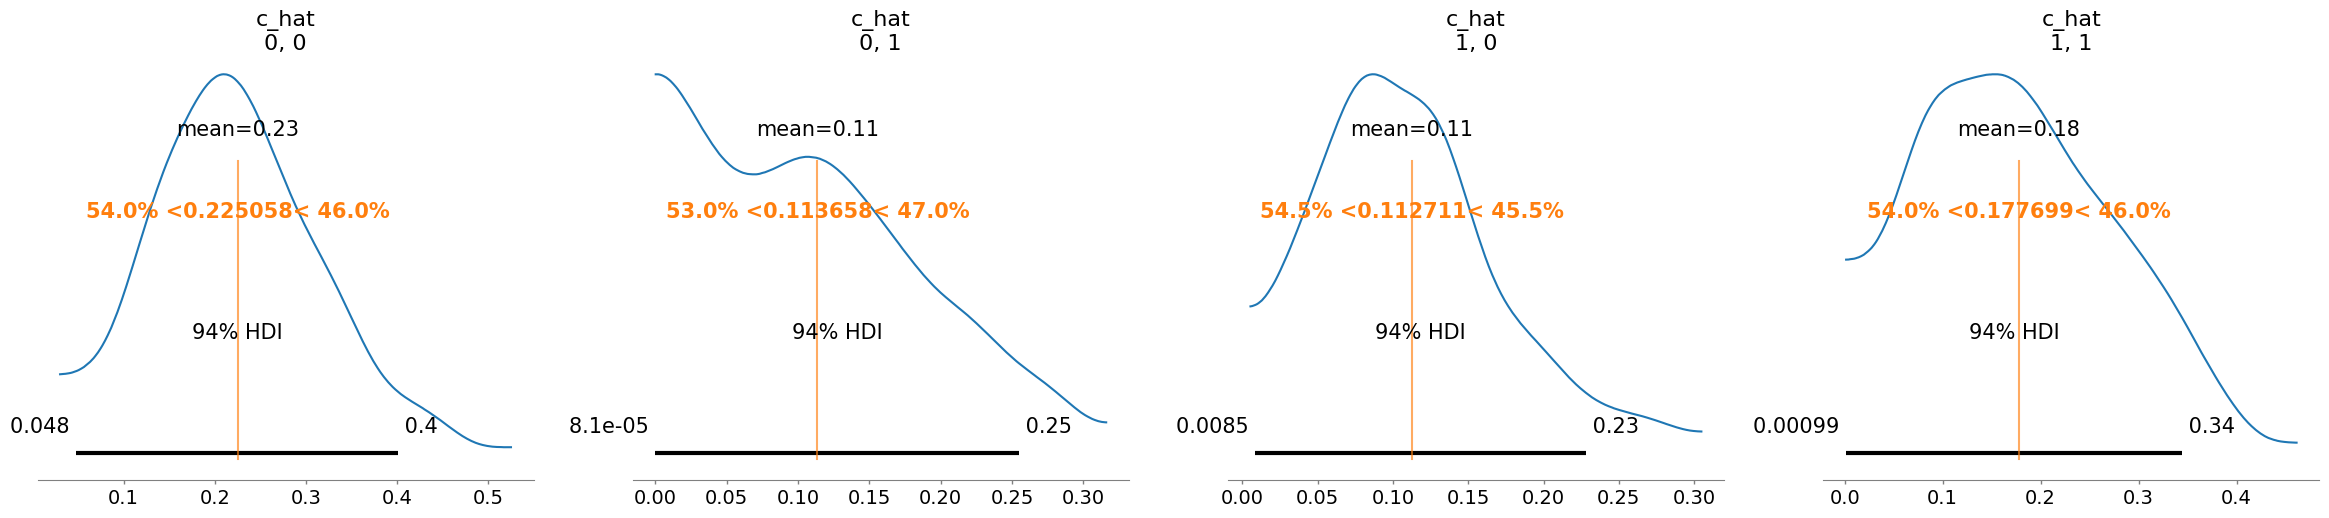

Plotting posterior for m_hat


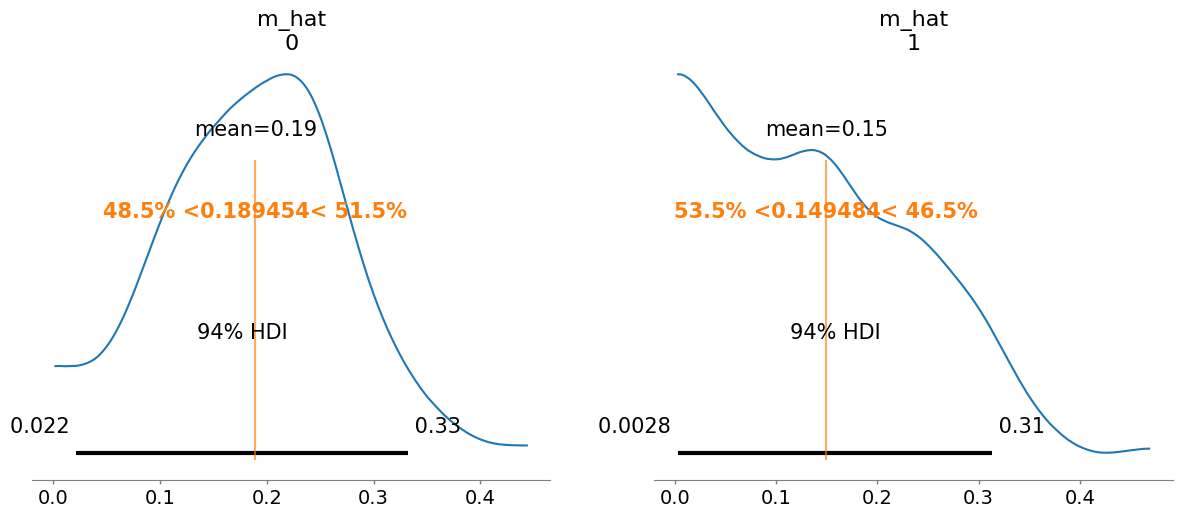

Plotting posterior for r_hat


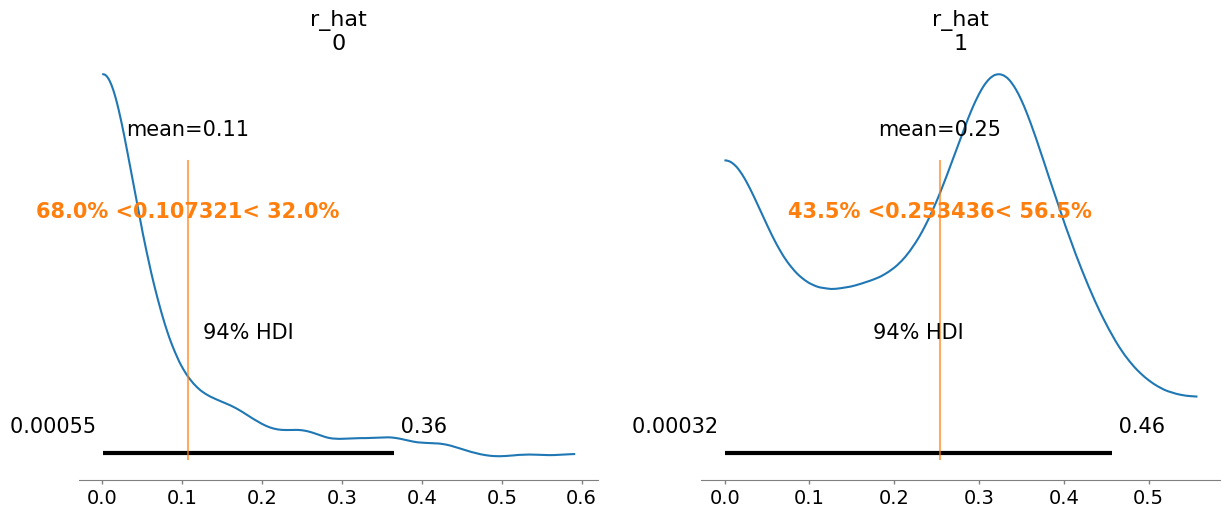

Plotting posterior for K_hat


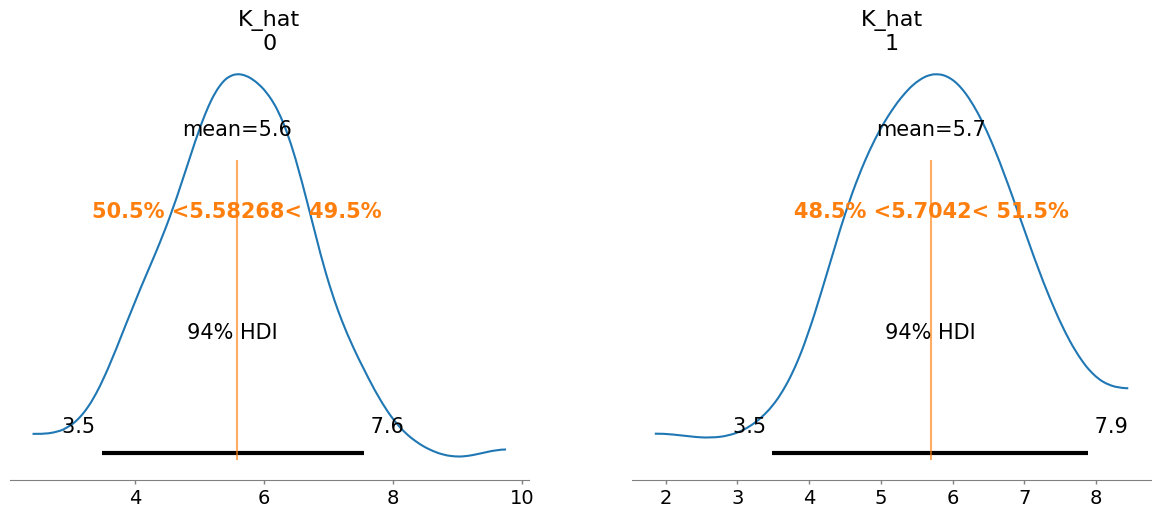

Moved 6 posterior plots to output folder


In [11]:
import glob
import shutil

inference.plot_posterior(idata)

# Move all the generated posterior plot files to output folder
posterior_files = glob.glob("plot-posterior-*.pdf")
for file in posterior_files:
    shutil.move(file, os.path.join(output_folder, file))

print(f"Moved {len(posterior_files)} posterior plots to output folder")




In [12]:
# To plot summary statistics of the posterior distributions, delete as appropriate
summary = az.summary(idata, var_names=["tau_hat", "w_hat","c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
print("Summary Statistics:")
print(summary[["mean", "sd", "r_hat"]])

# Also save to text file
summary[["mean", "sd", "r_hat"]].to_csv(os.path.join(output_folder, 'summary_statistics.txt'), sep='\t')
print("Saved summary statistics to summary_statistics.txt")

# Save posterior samples to file
az.to_netcdf(idata, os.path.join(output_folder, 'model_posterior.nc'))


#az.plot_trace(idata, var_names=["tau_hat", "w_hat","c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
az.plot_trace(idata, var_names=["c_hat", "sigma"])
plt.savefig(os.path.join(output_folder, 'posterior-trace.jpg'), dpi=300, bbox_inches='tight')
plt.close()
print("Saved posterior trace plot")



Summary Statistics:
              mean     sd  r_hat
tau_hat[0]   1.321  0.272   1.06
tau_hat[1]   1.371  0.298   1.02
w_hat[0]     0.372  0.219   1.13
w_hat[1]     0.174  0.230   1.41
c_hat[0, 0]  0.225  0.091   1.07
c_hat[0, 1]  0.114  0.078   1.12
c_hat[1, 0]  0.113  0.061   1.04
c_hat[1, 1]  0.178  0.099   1.18
m_hat[0]     0.189  0.082   1.03
m_hat[1]     0.149  0.099   1.04
r_hat[0]     0.107  0.125   1.28
r_hat[1]     0.253  0.142   1.28
K_hat[0]     5.583  1.120   1.01
K_hat[1]     5.704  1.180   1.03
sigma[0]     0.047  0.004   1.02
Saved summary statistics to summary_statistics.txt
Saved posterior trace plot


In [15]:
## Plot the CRM using median values from the posterior samples

y0_species = yobs[0, :num_species]  # Shape: (nsp,)

# Estimate reasonable resource initial conditions
y0_resources = np.full(num_resources, 0.05)

# Combine them
init_species = np.concatenate([y0_species, y0_resources])  # Shape: (nsp + nr,)


# inferred parameters - adjust as appropriate
tau_h = np.median(idata.posterior["tau_hat"].values, axis=(0,1))
w_h = np.median(idata.posterior["w_hat"].values, axis=(0,1))
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1))
m_h = np.median(idata.posterior["m_hat"].values, axis=(0,1))
r_h = np.median(idata.posterior["r_hat"].values, axis=(0,1))
K_h = np.median(idata.posterior["K_hat"].values, axis=(0,1))


# # Individual parameter comparisons with specific filenames
# params_to_compare = [('tau', tau, tau_h), ('w', w, w_h), ('c', c, c_h), ('m', m, m_h), ('r', r, r_h), ('K', K, K_h)]
# #params_to_compare = [('c', c, c_h)]



# for param_name, true_val, pred_val in params_to_compare:
#     compare_params(**{param_name: (true_val, pred_val)})
#     plt.savefig(os.path.join(output_folder, f'parameter_comparison_{param_name}.jpg'), dpi=300, bbox_inches='tight')
#     plt.close()
#     print(f"Saved {param_name} parameter comparison plot")

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau_h,
                         w = w_h,
                         c = c_h,
                         m = m_h,
                         r = r_h,
                         K = K_h)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'co_EcN_Sent_EAB12_fitting.csv')
plt.savefig(os.path.join(output_folder, 'CRM_prediction.jpg'), dpi=300, bbox_inches='tight')
plt.close()
print("Saved CRM prediction plot")



TypeError: 'module' object is not callable